# CNN Model

# Import All Necessary Libraries and Create File Paths

In [1]:
import os
import sys
import pandas as pd
import numpy as np

# Image Generator
from keras.preprocessing.image import ImageDataGenerator

# Plotting
import matplotlib.pyplot as plt

# Modelling CNN
import tensorflow as tf
from numba import cuda
import glob 

In [2]:
# folder path or file path constants that will be used in this project

# Root Directory (between 'F:' or 'D:'' depends on the external drive)
ROOT = "D:"

# Folder inside D:\\wildfire-sumatera-dataset
WILDFIRE_SUMATERA_DATASET_FOLDER_PATH = f"{ROOT}\\wildfire-sumatera-dataset"


# Folders and metadatas inside D:\\wildfire-sumatera-dataset
WILDFIRE_SUMATERA_GEOTIFF_FOLDER_PATH        = f"{WILDFIRE_SUMATERA_DATASET_FOLDER_PATH}\\wildfire-sumatera-geotiff"
WILDFIRE_SUMATERA_JPEG_FOLDER_PATH           = f"{WILDFIRE_SUMATERA_DATASET_FOLDER_PATH}\\wildfire-sumatera-jpeg"

# Files (.csv) and metadatas inside D:\\wildfire-sumatera-dataset
METADATA_LANDSAT_8_FILE_PATH  = f"{WILDFIRE_SUMATERA_DATASET_FOLDER_PATH}\\metadata_landsat_8_new.csv"
METADATA_SENTINEL_2_FILE_PATH = f"{WILDFIRE_SUMATERA_DATASET_FOLDER_PATH}\\metadata_sentinel_2_new.csv"



# Folders inside D:\\wildfire-sumatera-dataset\\wildfire-sumatera-geotiff
SENTINEL_2_GEOTIFF_FOLDER_PATH = f"{WILDFIRE_SUMATERA_GEOTIFF_FOLDER_PATH}\\sentinel-2"
LANDSAT_8_GEOTIFF_FOLDER_PATH  = f"{WILDFIRE_SUMATERA_GEOTIFF_FOLDER_PATH}\\landsat-8"


# Folders inside D:\\wildfire-sumatera-dataset\\wildfire-sumatera-jpeg
SENTINEL_2_JPEG_FOLDER_PATH = f"{WILDFIRE_SUMATERA_JPEG_FOLDER_PATH}\\sentinel-2"
LANDSAT_8_JPEG_FOLDER_PATH  = f"{WILDFIRE_SUMATERA_JPEG_FOLDER_PATH}\\landsat-8"



# Folders inside D:\\wildfire-sumatera-dataset\\wildfire-sumatera-geotiff\\landsat-8
LANDSAT_8_PREFIRE_GEOTIFF_FOLDER_PATH  = f"{LANDSAT_8_GEOTIFF_FOLDER_PATH}\\prefire"
LANDSAT_8_POSTFIRE_GEOTIFF_FOLDER_PATH = f"{LANDSAT_8_GEOTIFF_FOLDER_PATH}\\postfire"

# Folders inside D:\\wildfire-sumatera-dataset\\wildfire-sumatera-geotiff\\sentinel-2
SENTINEL_2_PREFIRE_GEOTIFF_FOLDER_PATH  = f"{SENTINEL_2_GEOTIFF_FOLDER_PATH}\\prefire"
SENTINEL_2_POSTFIRE_GEOTIFF_FOLDER_PATH = f"{SENTINEL_2_GEOTIFF_FOLDER_PATH}\\postfire"


dirs = [
    WILDFIRE_SUMATERA_DATASET_FOLDER_PATH,
    WILDFIRE_SUMATERA_GEOTIFF_FOLDER_PATH, 
    WILDFIRE_SUMATERA_JPEG_FOLDER_PATH,
    
    SENTINEL_2_GEOTIFF_FOLDER_PATH, 
    LANDSAT_8_GEOTIFF_FOLDER_PATH,
    SENTINEL_2_JPEG_FOLDER_PATH,
    LANDSAT_8_JPEG_FOLDER_PATH,
    
    LANDSAT_8_PREFIRE_GEOTIFF_FOLDER_PATH,
    LANDSAT_8_POSTFIRE_GEOTIFF_FOLDER_PATH,
    SENTINEL_2_PREFIRE_GEOTIFF_FOLDER_PATH,
    SENTINEL_2_POSTFIRE_GEOTIFF_FOLDER_PATH,
]

for dir_ in dirs:
    if not os.path.exists(dir_):
        os.mkdir(dir_)
        print(f"{dir_} has been created")
    else:
        print(f"{dir_} already exist")

D:\wildfire-sumatera-dataset already exist
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff already exist
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg already exist
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2 already exist
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8 already exist
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2 already exist
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8 already exist
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\prefire already exist
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire already exist
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\prefire already exist
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire already exist


# Constants

In [3]:
RANDOM_STATE = 42
BATCH_SIZE = 64
SEED = RANDOM_STATE
WIDTH = 256
HEIGHT = 256
CHANNEL = 3
INPUT_SIZE = (WIDTH, HEIGHT, CHANNEL)

# Prepare Data

In [4]:
# landsat-8
landsat_df = pd.read_csv(METADATA_LANDSAT_8_FILE_PATH)
df = pd.DataFrame()
df['file_paths_jpeg'] =  landsat_df.loc[:, 'file_paths_jpeg']
df['image_condition'] =  landsat_df.loc[:, 'image_condition']
df['class'] = landsat_df.loc[:, 'class_by_mean'].astype(str)
df = df[df['image_condition'] == 1]
df.reset_index()
df

,file_paths_jpeg,image_condition,class
0,\wildfire-sumatera-dataset\wildfire-sumatera-i...,1,0
1,\wildfire-sumatera-dataset\wildfire-sumatera-i...,1,0
2,\wildfire-sumatera-dataset\wildfire-sumatera-i...,1,0
3,\wildfire-sumatera-dataset\wildfire-sumatera-i...,1,0
4,\wildfire-sumatera-dataset\wildfire-sumatera-i...,1,0
...,...,...,...
7834,\wildfire-sumatera-dataset\wildfire-sumatera-i...,1,0
7835,\wildfire-sumatera-dataset\wildfire-sumatera-i...,1,0
7836,\wildfire-sumatera-dataset\wildfire-sumatera-i...,1,0
7837,\wildfire-sumatera-dataset\wildfire-sumatera-i...,1,0


In [5]:
# spliting data for testing and training
from sklearn.model_selection import train_test_split

# Spliting based on class
# split between train and val_test with 20% split ratio
x_train, x_val_test, y_train, y_val_test, = train_test_split(
    df['file_paths_jpeg'], 
    df['class'], 
    stratify = df['class'],
    test_size = 0.2,
    random_state = RANDOM_STATE
)

# split val_test to val and test with 50% split ratio
x_val, x_test, y_val, y_test = train_test_split(
    x_val_test, 
    y_val_test, 
    stratify = y_val_test,
    test_size = 0.5,
    random_state = RANDOM_STATE
)

In [6]:
print("train image = {} and label = {}".format(len(x_train), len(y_train)))
print('Class quantity in train')
display(y_train.value_counts())
print("val image = {} and label = {}".format(len(x_val), len(y_val)))
print('Class quantity in val')
display(y_val.value_counts())
print("test image = {} and label = {}".format(len(x_test), len(y_test)))
print('Class quantity in test')
display(y_test.value_counts())

train image = 6268 and label = 6268
Class quantity in train


0    5431
1     837
Name: class, dtype: int64

val image = 784 and label = 784
Class quantity in val


0    679
1    105
Name: class, dtype: int64

test image = 784 and label = 784
Class quantity in test


0    680
1    104
Name: class, dtype: int64

In [7]:
y_train.values

array(['0', '0', '0', ..., '0', '0', '1'], dtype=object)

In [8]:
train_dict = {
    'file_paths_jpeg': x_train.values,
    'class': y_train.values,
}
train_df = pd.DataFrame(data=train_dict)

val_dict = {
    'file_paths_jpeg': x_val.values,
    'class': y_val.values,
}
val_df = pd.DataFrame(data=val_dict)

test_dict = {
    'file_paths_jpeg': x_test.values,
    'class': y_test.values,
}
test_df = pd.DataFrame(data=test_dict)

In [9]:
display(train_df.head())
display(val_df.head())
display(test_df.head())

,file_paths_jpeg,class
0,\wildfire-sumatera-dataset\wildfire-sumatera-i...,0
1,\wildfire-sumatera-dataset\wildfire-sumatera-i...,0
2,\wildfire-sumatera-dataset\wildfire-sumatera-i...,0
3,\wildfire-sumatera-dataset\wildfire-sumatera-i...,0
4,\wildfire-sumatera-dataset\wildfire-sumatera-i...,1


,file_paths_jpeg,class
0,\wildfire-sumatera-dataset\wildfire-sumatera-i...,1
1,\wildfire-sumatera-dataset\wildfire-sumatera-i...,0
2,\wildfire-sumatera-dataset\wildfire-sumatera-i...,0
3,\wildfire-sumatera-dataset\wildfire-sumatera-i...,0
4,\wildfire-sumatera-dataset\wildfire-sumatera-i...,0


,file_paths_jpeg,class
0,\wildfire-sumatera-dataset\wildfire-sumatera-i...,0
1,\wildfire-sumatera-dataset\wildfire-sumatera-i...,0
2,\wildfire-sumatera-dataset\wildfire-sumatera-i...,0
3,\wildfire-sumatera-dataset\wildfire-sumatera-i...,0
4,\wildfire-sumatera-dataset\wildfire-sumatera-i...,0


# Create generator (Image Augmentation)

In [10]:
train_generator = ImageDataGenerator(
    rescale= 1./255,
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range= 0.2,
    shear_range= 0.2,
)

val_generator = ImageDataGenerator(
    rescale= 1./255,
)

test_generator = ImageDataGenerator(
    rescale= 1./255,
)

In [11]:
# Applying Generator by using data from dataframe
train_data = train_generator.flow_from_dataframe(
    dataframe = train_df,
    directory = LANDSAT_8_JPEG_FOLDER_PATH,
    x_col = 'file_paths_jpeg',
    y_col = 'class',
    batch_size = BATCH_SIZE,
    target_size = (WIDTH,HEIGHT),
    class_mode = "binary",
)

validation_data = val_generator.flow_from_dataframe(
    dataframe = val_df,
    directory = LANDSAT_8_JPEG_FOLDER_PATH,
    x_col = 'file_paths_jpeg',
    y_col = 'class',
    batch_size = BATCH_SIZE,
    seed = SEED,
    target_size = (WIDTH,HEIGHT),
    class_mode = "binary",
)

test_data = test_generator.flow_from_dataframe(
    dataframe = test_df,
    directory = LANDSAT_8_JPEG_FOLDER_PATH,
    x_col = 'file_paths_jpeg',
    y_col = 'class',
    batch_size = len(test_df.index),
    seed = SEED,
    target_size = (WIDTH,HEIGHT),
    class_mode = "binary")

Found 6268 validated image filenames belonging to 2 classes.
Found 784 validated image filenames belonging to 2 classes.
Found 784 validated image filenames belonging to 2 classes.


### Create Model Prototype version 1

In [12]:
import tensorflow as tf
from keras.models import Sequential 
from keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D, Activation


def cnn_model(input_shape):
    # Create Sequential model
    model = tf.keras.Sequential()
    
    # Convolution 2D Layer with kernel size 3x3 (filters=32)
    model.add(tf.keras.layers.Conv2D(
        filters=16, 
        kernel_size=(3, 3), 
        input_shape=input_shape, 
        activation='relu',
    ))
    # Max Pooling layer (2D) with pool size of 2x2 (default)
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    
    # Convolution 2D Layer with kernel size 3x3 (filters=64)
    model.add(tf.keras.layers.Conv2D(
        filters=32, 
        kernel_size=(3, 3), 
        activation='relu',
    ))
    # Max Pooling layer (2D) with pool size of 2x2 (default)
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    
    # Convolution 2D Layer with kernel size 3x3 (filters=128)
    model.add(tf.keras.layers.Conv2D(
        filters=64, 
        kernel_size=(3, 3),
        activation='relu',
    ))
    # Max Pooling layer (2D) with pool size of 2x2 (default)
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    
    # Flatten layer
    model.add(tf.keras.layers.Flatten())
    # Fully Connected Layer
    model.add(tf.keras.layers.Dense(units=64, activation='relu'))
    # Drop Out Layer
    model.add(tf.keras.layers.Dropout(0.5))
    
    # Output model (multiclass)
    model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))
    
    return model

In [13]:
# check if gpu is detected and ready to be used by tensorflow for neural network training process
print("GPU is available, Device = {}".format(tf.config.list_physical_devices("GPU"))
      if tf.config.list_physical_devices("GPU") else "GPU is not available")

GPU is available, Device = [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [14]:
# Reset Device and Free Memory from GPU
from numba import cuda
device = cuda.get_current_device()
device.reset()

In [15]:
model = cnn_model(INPUT_SIZE)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 64)       0

In [16]:
imgs, labels = next(train_data)

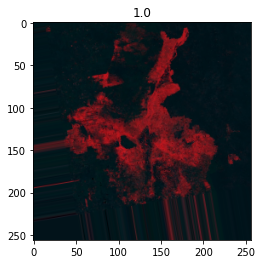

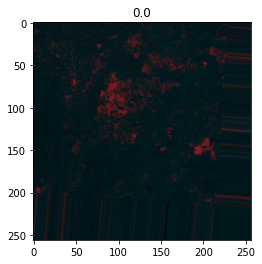

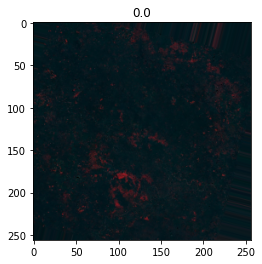

In [17]:
counter = 0
for img, label in zip(imgs, labels):
    if counter > 2:
        break
    plt.title(label)
    plt.imshow(img)
    plt.show()
    counter += 1

# Implement callbacks

In [18]:
index = len(glob.glob('./best_cnn_model*')) + 1
print(index)

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5, verbose = 2),
    tf.keras.callbacks.ModelCheckpoint(
        filepath = './best_cnn_model_{}'.format(index), 
        monitor = 'val_accuracy'.format(index), 
        save_best_only = True,
        mode = 'max', 
        verbose = 2,
    )
]

model.compile(
    optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001),
    loss= tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy'],
)

3


In [19]:
with tf.device('/GPU:0'):
    history = model.fit(
    train_data,
    validation_data=validation_data,
    epochs=10,
    workers=6,
#     steps_per_epoch=train_data.samples//BATCH_SIZE,
#     validation_steps=validation_data.samples//BATCH_SIZE,
    callbacks=callbacks,
    ) 

Epoch 1/10
98/98 [==============================] - ETA: 0s - loss: 0.2107 - accuracy: 0.9266
Epoch 1: val_accuracy improved from -inf to 0.99872, saving model to .\best_cnn_model_3


INFO:tensorflow:Assets written to: .\best_cnn_model_3\assets


INFO:tensorflow:Assets written to: .\best_cnn_model_3\assets


98/98 [==============================] - 63s 513ms/step - loss: 0.2107 - accuracy: 0.9266 - val_loss: 0.0482 - val_accuracy: 0.9987
Epoch 2/10
98/98 [==============================] - ETA: 0s - loss: 0.0643 - accuracy: 0.9813
Epoch 2: val_accuracy improved from 0.99872 to 1.00000, saving model to .\best_cnn_model_3


INFO:tensorflow:Assets written to: .\best_cnn_model_3\assets


INFO:tensorflow:Assets written to: .\best_cnn_model_3\assets


98/98 [==============================] - 43s 424ms/step - loss: 0.0643 - accuracy: 0.9813 - val_loss: 0.0086 - val_accuracy: 1.0000
Epoch 3/10
98/98 [==============================] - ETA: 0s - loss: 0.0512 - accuracy: 0.9831
Epoch 3: val_accuracy did not improve from 1.00000
98/98 [==============================] - 45s 428ms/step - loss: 0.0512 - accuracy: 0.9831 - val_loss: 0.0104 - val_accuracy: 0.9987
Epoch 4/10
98/98 [==============================] - ETA: 0s - loss: 0.0422 - accuracy: 0.9861
Epoch 4: val_accuracy did not improve from 1.00000
98/98 [==============================] - 44s 427ms/step - loss: 0.0422 - accuracy: 0.9861 - val_loss: 0.0021 - val_accuracy: 1.0000
Epoch 5/10
98/98 [==============================] - ETA: 0s - loss: 0.0335 - accuracy: 0.9888
Epoch 5: val_accuracy did not improve from 1.00000
98/98 [==============================] - 42s 404ms/step - loss: 0.0335 - accuracy: 0.9888 - val_loss: 0.0112 - val_accuracy: 0.9974
Epoch 6/10
98/98 [===================

In [20]:
def evaluate_model(history):
    plt.figure(figsize=(10, 15))
    plt.subplot(211)
    plt.title('Accuracy vs Validation Accuracy')
    plt.plot(history.history['accuracy'], label='train accuracy')
    plt.plot(history.history['val_accuracy'], label='validation accuracy')
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(10, 15))
    plt.subplot(212)
    plt.title('Loss vs Validation Loss')
    plt.plot(history.history['loss'], label='train loss')
    plt.plot(history.history['val_loss'], label='validation loss')
    plt.legend()
    plt.show()

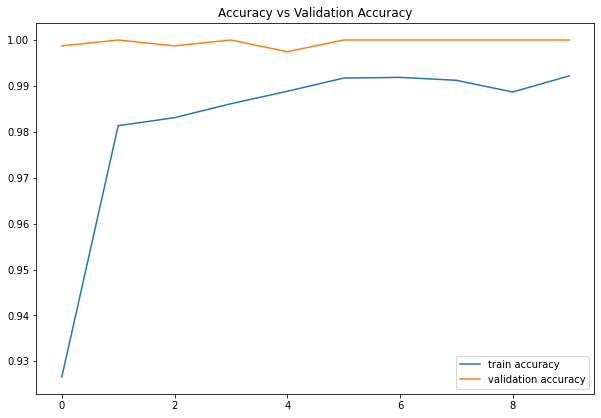

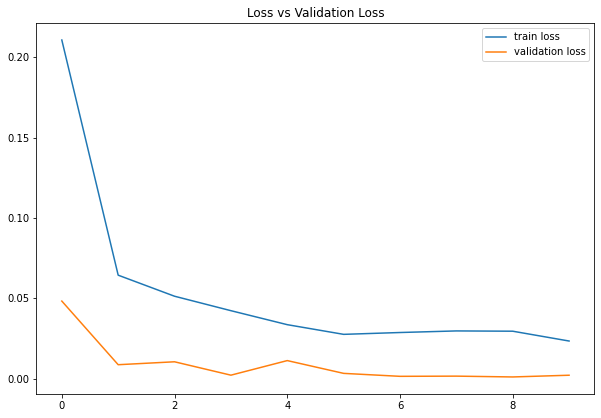

In [21]:
evaluate_model(history)

In [25]:
model.predict(test_generator)

ValueError: Failed to find data adapter that can handle input: <class 'keras.preprocessing.image.ImageDataGenerator'>, <class 'NoneType'>